In [34]:
import zipfile
import os

zip_path = "/content/archive.zip"
extract_path = "/content/fracture_dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /content/fracture_dataset


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from PIL import Image

In [36]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

TRAIN_PATH = "/content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train"
VAL_PATH   = "/content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
TEST_PATH  = "/content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"


In [37]:
def remove_corrupt_images(folder_path):
    removed = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                print(f"Removing corrupt image: {file_path}")
                os.remove(file_path)
                removed += 1
    print(f"Total removed corrupt images in {folder_path}: {removed}")

remove_corrupt_images(TRAIN_PATH)
remove_corrupt_images(VAL_PATH)
remove_corrupt_images(TEST_PATH)

Total removed corrupt images in /content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train: 0
Total removed corrupt images in /content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val: 0
Total removed corrupt images in /content/fracture_dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test: 0


In [38]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names = train_ds_raw.class_names
print("Classes:", class_names)

train_ds = train_ds_raw.map(lambda x, y: (x, y)).apply(tf.data.experimental.ignore_errors())

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = val_ds_raw.map(lambda x, y: (x, y)).apply(tf.data.experimental.ignore_errors())

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = test_ds_raw.map(lambda x, y: (x, y)).apply(tf.data.experimental.ignore_errors())


Found 9246 files belonging to 2 classes.
Classes: ['fractured', 'not fractured']
Found 829 files belonging to 2 classes.
Found 506 files belonging to 2 classes.


In [39]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [41]:
num_classes = 2
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print("Frozen layers:", fine_tune_at)
print("Trainable layers:", len(base_model.layers) - fine_tune_at)

inputs = layers.Input(shape=(224,224,3))
x = data_aug(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

Frozen layers: 122
Trainable layers: 53


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 224, 224,  │          0 │ input_layer_16[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 224, 224)  │          0 │ sequential_4[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 224, 224)  │          0 │ sequential_4[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, 224, 224)  │          0 │ sequential_4[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_5 (Stack)     │ (None, 224, 224,  │          0 │ get_item_15[0][0… │
│                     │ 3)                │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 224, 224,  │          0 │ stack_5[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_5[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2)         │        514 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,120,962 (92.01 MB)

 Trainable params: 17,742,594 (67.68 MB)

 Non-trainable params: 6,378,368 (24.33 MB)

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [43]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
    572/Unknown 102s 139ms/step - accuracy: 0.8772 - loss: 0.3290

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


572/572 ━━━━━━━━━━━━━━━━━━━━ 109s 151ms/step - accuracy: 0.8773 - loss: 0.3288 - val_accuracy: 0.9728 - val_loss: 0.0770 - learning_rate: 1.0000e-04
Epoch 2/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 84s 147ms/step - accuracy: 0.9814 - loss: 0.0551 - val_accuracy: 0.9700 - val_loss: 0.0803 - learning_rate: 1.0000e-04
Epoch 3/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 83s 146ms/step - accuracy: 0.9850 - loss: 0.0436 - val_accuracy: 0.9864 - val_loss: 0.0482 - learning_rate: 1.0000e-04
Epoch 4/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 83s 144ms/step - accuracy: 0.9931 - loss: 0.0200 - val_accuracy: 0.9823 - val_loss: 0.0375 - learning_rate: 1.0000e-04
Epoch 5/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step - accuracy: 0.9875 - loss: 0.0341 - val_accuracy: 0.9877 - val_loss: 0.0354 - learning_rate: 1.0000e-04
Epoch 6/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - accuracy: 0.9934 - loss: 0.0215 - val_accuracy: 0.9959 - val_loss: 0.0135 - learning_rate: 1.0000e-04
Epoch 7/15
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step -

In [44]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9936 - loss: 0.0210
Test Accuracy: 99.27%


In [50]:
model.save("/content/fracture_full_model.keras")

Saving images.jpeg to images (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


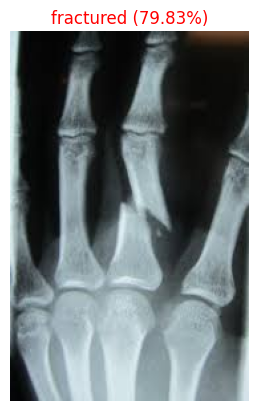

In [51]:
import tensorflow as tf
from google.colab import files
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

model = tf.keras.models.load_model("/content/fracture_full_model.keras")

img = Image.open(img_path).convert("RGB")
img_resized = img.resize((224,224))

img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

preds = model.predict(img_array)

class_names = ['fractured', 'not fractured']

idx = np.argmax(preds[0])
label = class_names[idx]
conf = preds[0][idx]

plt.imshow(img)
plt.axis("off")
plt.title(f"{label} ({conf*100:.2f}%)", color="red")
plt.show()

Saving images (1).jpeg to images (1) (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


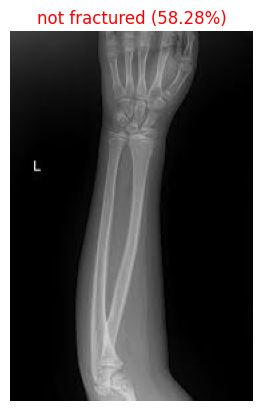

In [52]:
import tensorflow as tf
from google.colab import files
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

model = tf.keras.models.load_model("/content/fracture_full_model.keras")

img = Image.open(img_path).convert("RGB")
img_resized = img.resize((224,224))

img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

preds = model.predict(img_array)

class_names = ['fractured', 'not fractured']

idx = np.argmax(preds[0])
label = class_names[idx]
conf = preds[0][idx]

plt.imshow(img)
plt.axis("off")
plt.title(f"{label} ({conf*100:.2f}%)", color="red")
plt.show()

Saving 31aa767555b74dd074199e58b6a18a_big_gallery.jpeg to 31aa767555b74dd074199e58b6a18a_big_gallery.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


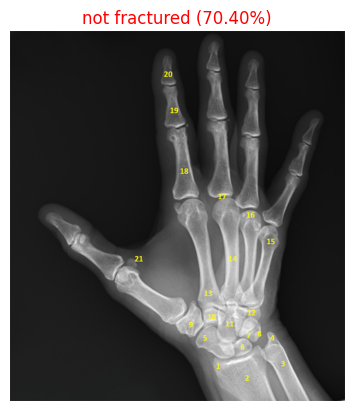

In [55]:
import tensorflow as tf
from google.colab import files
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

model = tf.keras.models.load_model("/content/fracture_full_model.keras")

img = Image.open(img_path).convert("RGB")
img_resized = img.resize((224,224))

img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

preds = model.predict(img_array)

class_names = ['fractured', 'not fractured']

idx = np.argmax(preds[0])
label = class_names[idx]
conf = preds[0][idx]

plt.imshow(img)
plt.axis("off")
plt.title(f"{label} ({conf*100:.2f}%)", color="red")
plt.show()

Saving Screenshot 2026-02-22 173642.png to Screenshot 2026-02-22 173642.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


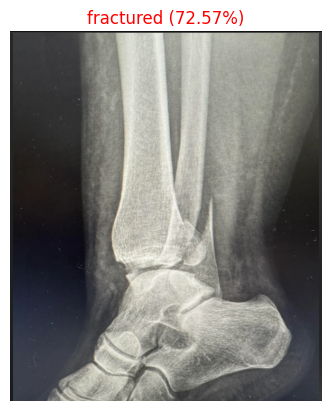

In [54]:
import tensorflow as tf
from google.colab import files
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

model = tf.keras.models.load_model("/content/fracture_full_model.keras")

img = Image.open(img_path).convert("RGB")
img_resized = img.resize((224,224))

img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

preds = model.predict(img_array)

class_names = ['fractured', 'not fractured']

idx = np.argmax(preds[0])
label = class_names[idx]
conf = preds[0][idx]

plt.imshow(img)
plt.axis("off")
plt.title(f"{label} ({conf*100:.2f}%)", color="red")
plt.show()